In [80]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Exploring data

## Loading

In [81]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2023-03-18 01:46:44--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  31.6MB/s    in 5.7s    

2023-03-18 01:46:50 (28.4 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]



In [82]:
!tar -xf cifar-10-python.tar.gz

In [83]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [84]:
meta_data = unpickle('/content/cifar-10-batches-py/batches.meta')

In [85]:
data_batch_1 = unpickle('/content/cifar-10-batches-py/data_batch_1')

In [86]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [87]:
for item in data_batch_1:
    print(item, type(data_batch_1[item]))

b'batch_label' <class 'bytes'>
b'labels' <class 'list'>
b'data' <class 'numpy.ndarray'>
b'filenames' <class 'list'>


## Visualising

Text(0.5, 1.0, "b'frog'")

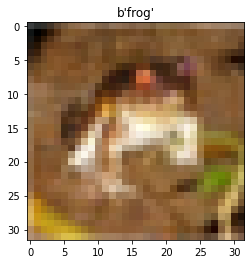

In [88]:
# label names
label_name = meta_data[b'label_names']
# take first image
image = data_batch_1[b'data'][0]
# take first image label index
label = data_batch_1[b'labels'][0]
# Reshape the image
image = image.reshape(3,32,32)
# Transpose the image
image = image.transpose(1,2,0)
# Display the image
plt.imshow(image)
plt.title(label_name[label])

In [89]:
X_train = data_batch_1[b'data']
print("Shape before reshape:", X_train.shape)

X_train = X_train.reshape(len(X_train),3,32,32)
print("Shape after reshape and before transpose:", X_train.shape)
# Transpose the whole data
X_train = X_train.transpose(0,2,3,1)
print("Shape after reshape and transpose:", X_train.shape)

Shape before reshape: (10000, 3072)
Shape after reshape and before transpose: (10000, 3, 32, 32)
Shape after reshape and transpose: (10000, 32, 32, 3)


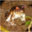

In [90]:
img = X_train[0]
img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
cv2_imshow(img)

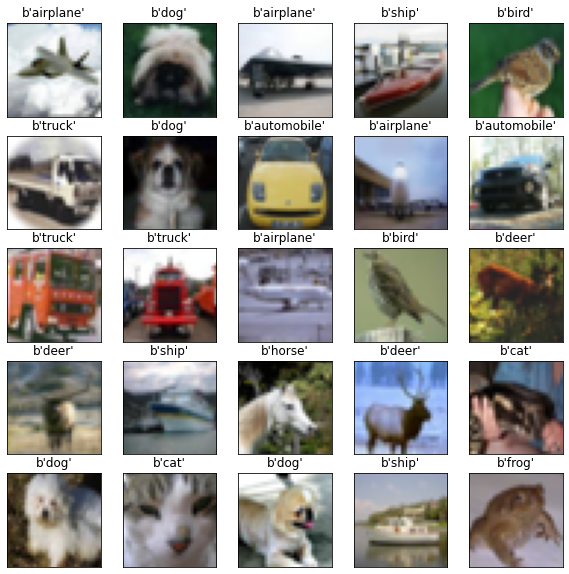

In [91]:
# take the images data from batch data
images = data_batch_1[b'data']
# reshape and transpose the images
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
# take labels of the images 
labels = data_batch_1[b'labels']
# label names of the images
label_names = meta_data[b'label_names']


# dispaly random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
# take labels for these images only
labels = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

## Trying sift

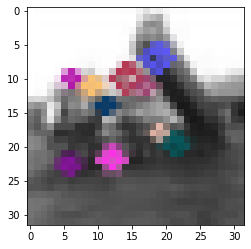

In [92]:
img = X_train[2]
gray= cv.cvtColor(img,cv.COLOR_RGB2GRAY)

sift = cv.SIFT_create()
# params: img, mask
kp, des = sift.detectAndCompute(gray, None)
imgc = img.copy()
img_kp = cv.drawKeypoints(gray, kp, imgc, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_kp)

In [93]:
des.shape, des.dtype

((13, 128), dtype('float32'))

# Feature extraction

## function to extract limited descriptors

In [94]:
sift = cv.SIFT_create()
def get_sift(img):
  gray= cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  kp, des = sift.detectAndCompute(gray, None)
  if des is not None:
    np.random.shuffle(des)
    return des[:8, :] # right now up to 8 random descriptors from one image
  else:  
    return np.array([]).reshape(0, 128)  

In [95]:
des = get_sift(img)

In [96]:
des.shape

(8, 128)

## Load all of the train batches

In [97]:
meta_data = unpickle('/content/cifar-10-batches-py/batches.meta')
data_batches = []
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_1'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_2'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_3'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_4'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_5'))
images = []
labels = []
for i in range(len(data_batches)):
  images.append(data_batches[i][b'data'])
  labels.extend(data_batches[i][b'labels'])
images = np.array(images)
labels = np.array(labels)
label_names = meta_data[b'label_names']
images = images.reshape(-1,3,32,32).transpose(0,2,3,1)

label_names = meta_data[b'label_names']

### quick check

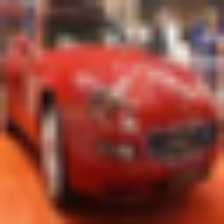

b'automobile'

In [98]:
img = cv.cvtColor(images[5], cv.COLOR_RGB2BGR)
img = cv.resize(img, (224,224))
cv2_imshow(img)
label_names[labels[5]]

## Stack all descriptors

In [99]:
descriptors = []
for image in images:
  des = get_sift(image)
  descriptors.extend(des)


In [100]:
descriptors = np.array(descriptors)
descriptors.shape

(380423, 128)

## Create clusters with KMeans

In [101]:
n_clusters = 75 # looks like more clusters=more precision
clusters = KMeans(n_clusters = n_clusters)
label_ = clusters.fit_predict(descriptors)
centers = clusters.cluster_centers_

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Cluster centers

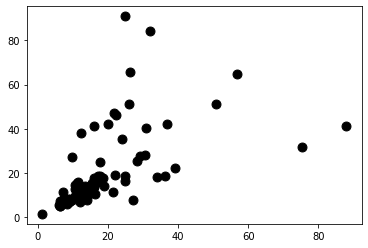

In [102]:
plt.scatter(centers[:,0] , centers[:,1] , s = 80, color = 'k')
plt.show()

In [103]:
des = get_sift(images[0])
clusters.predict(des)

array([50, 46, 14, 44, 22, 67, 29, 44], dtype=int32)

## Get all descriptors and count frequencies of them getting into the clusters

In [104]:
def get_features(images):
  features = np.zeros((len(images), n_clusters))
  for i in range(len(images)):
    gray= cv.cvtColor(images[i], cv.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    if des is not None:
      pred = clusters.predict(des)
      for j in range(n_clusters):
        features[i][j] = np.sum(pred == j)
      features[i] = features[i] / len(pred)
  return features

In [105]:
features = get_features(images)

In [106]:
features.shape

(50000, 75)

## Do same with test batch

In [107]:
test_batch = unpickle('/content/cifar-10-batches-py/test_batch')
test_images = test_batch[b'data']

test_images = test_images.reshape(len(test_images),3,32,32).transpose(0,2,3,1)

test_labels = test_batch[b'labels']

test_features = get_features(test_images)
test_features.shape

(10000, 75)

# Train

## Classification with CatBoost

In [108]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
from catboost import CatBoostClassifier, Pool

In [110]:
labels = labels.astype(int)
test_labels = np.array(test_labels).astype(int)

In [111]:
train_pool = Pool(features, labels)
valid_pool = Pool(test_features, test_labels)

In [112]:
# param = {
#     'loss_function': 'CrossEntropy',
#     'learning_rate': 0.1,
#     'depth': 4
# }
model = CatBoostClassifier(task_type="GPU",devices='0')
model.fit(train_pool, eval_set=valid_pool, verbose=100, early_stopping_rounds=800)

Learning rate set to 0.156109
0:	learn: 2.2779963	test: 2.2795217	best: 2.2795217 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 1.9579802	test: 2.0255652	best: 2.0255652 (100)	total: 1.08s	remaining: 9.66s
200:	learn: 1.9075997	test: 2.0141059	best: 2.0141059 (200)	total: 1.97s	remaining: 7.81s
300:	learn: 1.8742295	test: 2.0095645	best: 2.0095645 (300)	total: 3.61s	remaining: 8.38s
400:	learn: 1.8486100	test: 2.0085576	best: 2.0083295 (383)	total: 5.65s	remaining: 8.45s
500:	learn: 1.8254359	test: 2.0083107	best: 2.0080262 (471)	total: 6.49s	remaining: 6.46s
600:	learn: 1.8048311	test: 2.0088672	best: 2.0080262 (471)	total: 7.31s	remaining: 4.85s
700:	learn: 1.7831450	test: 2.0092043	best: 2.0080262 (471)	total: 8.16s	remaining: 3.48s
800:	learn: 1.7629036	test: 2.0101113	best: 2.0080262 (471)	total: 9s	remaining: 2.23s
900:	learn: 1.7429928	test: 2.0111850	best: 2.0080262 (471)	total: 9.83s	remaining: 1.08s
999:	learn: 1.7244462	test: 2.0123855	best: 2.0080262 (471)	total: 10.6s	rem

### Score

In [113]:
model.score(valid_pool)

0.2741

## Classification with one linear layer using PyTorch

In [114]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn.functional as F


inp_dim = 3*32*32
out_dim = 10
model = nn.Sequential(
          nn.Linear(inp_dim, out_dim)
        )
batch_size = 4

In [116]:
meta_data = unpickle('/content/cifar-10-batches-py/batches.meta')
data_batches = []
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_1'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_2'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_3'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_4'))
data_batches.append(unpickle('/content/cifar-10-batches-py/data_batch_5'))
images = []
labels = []
for i in range(len(data_batches)):
  images.append(data_batches[i][b'data'])
  labels.extend(data_batches[i][b'labels'])
images = np.array(images)
labels = np.array(labels)
label_names = meta_data[b'label_names']
test_batch = unpickle('/content/cifar-10-batches-py/test_batch')
test_images = test_batch[b'data']
test_labels = test_batch[b'labels']

In [117]:
images.shape

(5, 10000, 3072)

In [118]:
images = images.reshape(50000, 3072)
images.shape

(50000, 3072)

In [119]:
test_images.shape

(10000, 3072)

In [120]:
labels

array([6, 9, 9, ..., 9, 1, 1])

### Dataloaders

In [121]:
from torch.utils.data import TensorDataset, DataLoader
train_x = F.normalize(torch.Tensor(images), p=2.0) # transform to torch tensor, normalize
train_y = torch.Tensor(labels)
train_y = train_y.type(torch.LongTensor)
train_dataset = TensorDataset(train_x,train_y) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True) # create your dataloader

In [122]:
test_x = F.normalize(torch.Tensor(test_images), p=2.0) # transform to torch tensor, normazile
test_y = torch.Tensor(test_labels)
test_y = test_y.type(torch.LongTensor)
test_dataset = TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

### Model

In [123]:
model = nn.Sequential(
    nn.Linear(in_features=3072, out_features=10)
)

In [124]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [125]:
model = model.to(device)

### Optimizer and loss function

In [126]:
import torch.optim as optim

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)
num_epoch = 10


### model train

In [127]:
train_losses=[]
valid_losses=[]

for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0

  model.train()
  for img,lbl in train_dataloader:

    img = img.to(device)
    lbl = lbl.to(device)
    optimizer.zero_grad()

    predict=model(img)

    loss=loss_fn(predict,lbl)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  model.eval()
  for img,lbl in test_dataloader:
    img = img.to(device)
    lbl = lbl.to(device)
    predict=model(img)
    loss=loss_fn(predict,lbl)
    valid_loss+=loss.item()

  train_loss=train_loss/len(train_dataloader.sampler) 
  valid_loss=valid_loss/len(test_dataloader.sampler)

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f}'.format(epoch,train_loss,valid_loss))  

Epoch:1 Train Loss:0.5626 valid Losss:0.5518
Epoch:2 Train Loss:0.5429 valid Losss:0.5361
Epoch:3 Train Loss:0.5296 valid Losss:0.5249
Epoch:4 Train Loss:0.5200 valid Losss:0.5168
Epoch:5 Train Loss:0.5126 valid Losss:0.5102
Epoch:6 Train Loss:0.5067 valid Losss:0.5048
Epoch:7 Train Loss:0.5018 valid Losss:0.5002
Epoch:8 Train Loss:0.4976 valid Losss:0.4964
Epoch:9 Train Loss:0.4940 valid Losss:0.4931
Epoch:10 Train Loss:0.4909 valid Losss:0.4901


### Score

In [128]:
cor, total = 0, 0

with torch.no_grad():
  for img, lbl in test_dataloader:
    img = img.to(device)
    lbl = lbl.to(device)
    img = img.view(img.shape[0], -1)
    probs = model(img)
    _, pred = torch.max(probs.data, 1)
    total += lbl.size(0)
    cor += (pred == lbl).sum().item()

In [129]:
cor / total

0.3447